### Merged Ensemble Model: VGG19 + MobileNet + ResNet50

## 1. Import Required Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from PIL import Image, ImageEnhance

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pre-trained Models
from tensorflow.keras.applications import VGG19, MobileNet, ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Mount Google Drive and Setup Paths

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Configuration
CONFIG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.0001,
    'EARLY_STOPPING_PATIENCE': 10,
    'REDUCE_LR_PATIENCE': 5,
    'TEST_SIZE': 0.2,
    'RANDOM_STATE': 42
}

# Dataset paths - Update this to your dataset location
DATA_DIR = '/content/drive/MyDrive/Lung Dataset'

# Verify dataset exists
if os.path.exists(DATA_DIR):
    print(f"✓ Dataset found at: {DATA_DIR}")
    print("\nDataset structure:")
    for item in os.listdir(DATA_DIR):
        print(f"  - {item}")
else:
    print(f"✗ Dataset NOT found at: {DATA_DIR}")
    print("Please update DATA_DIR to point to your dataset location")

✓ Dataset found at: /content/drive/MyDrive/Lung Dataset

Dataset structure:
  - Malignant
  - Normal
  - Benign


## 3. Data Loading and Preprocessing

In [4]:
def augment_image(image):
    """
    Apply data augmentation to images for better generalization.
    Includes random brightness and contrast adjustments.
    """
    image = Image.fromarray(np.uint8(image))
    # Random brightness adjustment
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    # Random contrast adjustment
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # Normalize to [0,1]
    image = np.array(image) / 255.0
    return image

def open_images(paths, augment=True):
    """
    Load and preprocess images from file paths.
    """
    images = []
    for path in paths:
        image = load_img(path, target_size=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
        if augment:
            image = augment_image(image)
        else:
            image = np.array(image) / 255.0
        images.append(image)
    return np.array(images)

print("✓ Data augmentation functions defined")

✓ Data augmentation functions defined


In [5]:
# Load dataset
def load_dataset(data_dir):
    """
    Load all images and labels from the dataset directory.
    Expected structure: DATA_DIR/class_name/image_files
    """
    all_paths = []
    all_labels = []

    # Get class names from subdirectories
    classes = sorted([d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d))])

    print(f"Found {len(classes)} classes: {classes}")

    # Create class to index mapping
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    # Load all image paths and labels
    for label in classes:
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_dir, image_name)
                    all_paths.append(image_path)
                    all_labels.append(class_to_idx[label])

    # Shuffle dataset
    all_paths, all_labels = shuffle(all_paths, all_labels,
                                     random_state=CONFIG['RANDOM_STATE'])

    # Print dataset statistics
    print(f"\nDataset Statistics:")
    print(f"Total images: {len(all_paths)}")
    for cls, idx in class_to_idx.items():
        count = all_labels.count(idx)
        print(f"  {cls}: {count} images")

    return all_paths, all_labels, class_to_idx

# Load the dataset
all_paths, all_labels, class_to_idx = load_dataset(DATA_DIR)
num_classes = len(class_to_idx)
class_names = list(class_to_idx.keys())

# Split into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels,
    test_size=CONFIG['TEST_SIZE'],
    random_state=CONFIG['RANDOM_STATE'],
    stratify=all_labels
)

print(f"\nTrain-Test Split:")
print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

Found 3 classes: ['Benign', 'Malignant', 'Normal']

Dataset Statistics:
Total images: 1097
  Benign: 120 images
  Malignant: 561 images
  Normal: 416 images

Train-Test Split:
Training images: 877
Testing images: 220


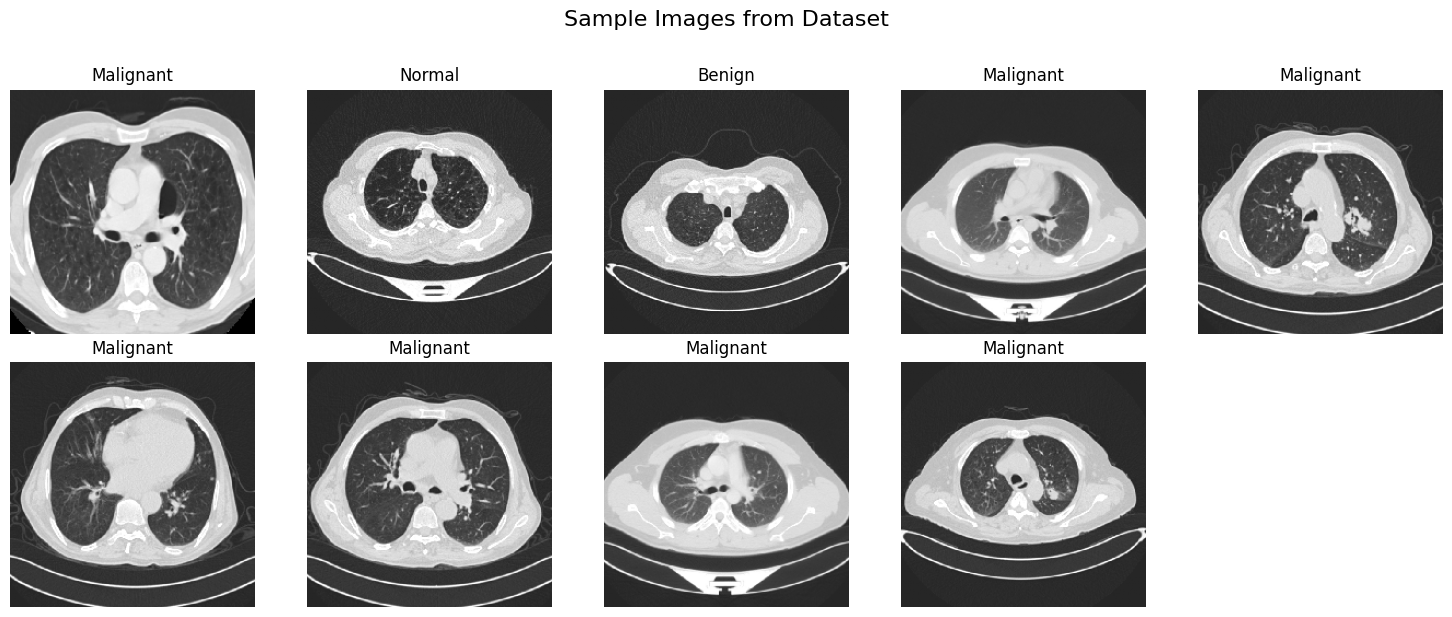

In [6]:
# Visualize sample images from the dataset
sample_images = open_images(train_paths[50:59], augment=False)
sample_labels = train_labels[50:59]

fig = plt.figure(figsize=(15, 6))
for idx in range(min(9, len(sample_images))):
    ax = fig.add_subplot(2, 5, idx + 1)
    plt.axis('off')
    plt.title(class_names[sample_labels[idx]], fontsize=12)
    plt.imshow(sample_images[idx])
plt.suptitle('Sample Images from Dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 4. Build Ensemble Model

Our ensemble architecture combines three pre-trained models:
1. **VGG19**: Known for its simplicity and strong feature extraction
2. **MobileNet**: Lightweight and efficient, good for capturing fine details
3. **ResNet50**: Deep residual learning for handling complex patterns

The models work in parallel, and their outputs are merged to make final predictions.

In [7]:
def build_ensemble_model(img_size=224, num_classes=3):
    """
    Build an ensemble model combining VGG19, MobileNet, and ResNet50.

    Architecture:
    - Each base model is loaded with ImageNet weights (transfer learning)
    - Base model layers are frozen to preserve learned features
    - Custom classification heads are added to each model
    - Outputs are concatenated and passed through dense layers
    - Final softmax layer produces class probabilities
    """
    # Define input shape
    input_shape = (img_size, img_size, 3)
    inputs = Input(shape=input_shape)

    # ========== Model 1: VGG19 ==========
    # Load pre-trained VGG19 without top classification layers
    vgg19_base = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Freeze base model layers
    vgg19_base.trainable = False

    # Add custom head for VGG19
    vgg19_output = vgg19_base(inputs)
    vgg19_output = GlobalAveragePooling2D(name='vgg19_gap')(vgg19_output)
    vgg19_output = BatchNormalization(name='vgg19_bn1')(vgg19_output)
    vgg19_output = Dense(256, activation='relu', name='vgg19_dense1')(vgg19_output)
    vgg19_output = Dropout(0.5, name='vgg19_dropout1')(vgg19_output)
    vgg19_output = Dense(128, activation='relu', name='vgg19_dense2')(vgg19_output)
    vgg19_output = Dropout(0.3, name='vgg19_dropout2')(vgg19_output)

    # ========== Model 2: MobileNet ==========
    # Load pre-trained MobileNet without top classification layers
    mobilenet_base = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Freeze base model layers
    mobilenet_base.trainable = False

    # Add custom head for MobileNet
    mobilenet_output = mobilenet_base(inputs)
    mobilenet_output = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_output)
    mobilenet_output = BatchNormalization(name='mobilenet_bn1')(mobilenet_output)
    mobilenet_output = Dense(256, activation='relu', name='mobilenet_dense1')(mobilenet_output)
    mobilenet_output = Dropout(0.5, name='mobilenet_dropout1')(mobilenet_output)
    mobilenet_output = Dense(128, activation='relu', name='mobilenet_dense2')(mobilenet_output)
    mobilenet_output = Dropout(0.3, name='mobilenet_dropout2')(mobilenet_output)

    # ========== Model 3: ResNet50 ==========
    # Load pre-trained ResNet50 without top classification layers
    resnet50_base = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Freeze base model layers
    resnet50_base.trainable = False

    # Add custom head for ResNet50
    resnet50_output = resnet50_base(inputs)
    resnet50_output = GlobalAveragePooling2D(name='resnet50_gap')(resnet50_output)
    resnet50_output = BatchNormalization(name='resnet50_bn1')(resnet50_output)
    resnet50_output = Dense(256, activation='relu', name='resnet50_dense1')(resnet50_output)
    resnet50_output = Dropout(0.5, name='resnet50_dropout1')(resnet50_output)
    resnet50_output = Dense(128, activation='relu', name='resnet50_dense2')(resnet50_output)
    resnet50_output = Dropout(0.3, name='resnet50_dropout2')(resnet50_output)

    # ========== Merge All Models ==========
    # Concatenate outputs from all three models
    merged = Concatenate(name='merge_models')([vgg19_output, mobilenet_output, resnet50_output])

    # Add fusion layers to combine features from all models
    merged = BatchNormalization(name='merged_bn')(merged)
    merged = Dense(256, activation='relu', name='merged_dense1')(merged)
    merged = Dropout(0.5, name='merged_dropout1')(merged)
    merged = Dense(128, activation='relu', name='merged_dense2')(merged)
    merged = Dropout(0.3, name='merged_dropout2')(merged)

    # Final output layer
    outputs = Dense(num_classes, activation='softmax', name='output')(merged)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='Ensemble_VGG19_MobileNet_ResNet50')

    return model

# Build the ensemble model
print("Building ensemble model...")
ensemble_model = build_ensemble_model(img_size=CONFIG['IMG_SIZE'], num_classes=num_classes)
print("✓ Ensemble model built successfully!")

# Display model summary
print(f"\nModel has {ensemble_model.count_params():,} total parameters")

Building ensemble model...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✓ Ensemble model built successfully!

Model has 48,005,635 total parameters


In [8]:
# Display detailed model summary
ensemble_model.summary()

Model: "Ensemble_VGG19_MobileNet_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ input_layer[0][0] │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19_gap           │ (None, 512)       │          0 │ vgg19[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_gap       │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_gap        │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19_bn1           │ (None, 512)       │      2,048 │ vgg19_gap[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_bn1       │ (None, 1024)      │      4,096 │ mobilenet_gap[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_bn1        │ (None, 2048)      │      8,192 │ resnet50_gap[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19_dense1        │ (None, 256)       │    131,328 │ vgg19_bn1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_dense1    │ (None, 256)       │    262,400 │ mobilenet_bn1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_dense1     │ (None, 256)       │    524,544 │ resnet50_bn1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19_dropout1      │ (None, 256)       │          0 │ vgg19_dense1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_dropout1  │ (None, 256)       │          0 │ mobilenet_dense1… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_dropout1   │ (None, 256)       │          0 │ resnet50_dense1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19_dense2        │ (None, 128)       │     32,896 │ vgg19_dropout1[0… │
│ (Dense)             │                   │            │                 

 Total params: 48,005,635 (183.13 MB)

 Trainable params: 1,156,739 (4.41 MB)

 Non-trainable params: 46,848,896 (178.71 MB)

In [9]:
# Visualize model architecture
try:
    keras.utils.plot_model(
        ensemble_model,
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )
except Exception as e:
    print(f"Could not plot model architecture: {e}")

## 5. Compile and Train the Model

In [10]:
# Compile the model
ensemble_model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled successfully")

✓ Model compiled successfully


In [11]:
# Define callbacks for training
callbacks = [
    # Save best model based on validation accuracy
    ModelCheckpoint(
        '/content/best_ensemble_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Stop training if no improvement
    EarlyStopping(
        monitor='val_accuracy',
        patience=CONFIG['EARLY_STOPPING_PATIENCE'],
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=CONFIG['REDUCE_LR_PATIENCE'],
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Training callbacks configured")

✓ Training callbacks configured


In [12]:
# Data generator for training
def datagen(paths, labels, batch_size=32, epochs=1, augment=True):
    """
    Generator that yields batches of images and labels.
    Includes data augmentation for training.
    """
    for epoch in range(epochs):
        # Shuffle data at the start of each epoch
        paths, labels = shuffle(paths, labels)

        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]

            # Load and preprocess images
            batch_images = open_images(batch_paths, augment=augment)

            yield batch_images, np.array(batch_labels)

print("✓ Data generator defined")

✓ Data generator defined


In [13]:
# Calculate steps per epoch
steps_per_epoch = len(train_paths) // CONFIG['BATCH_SIZE']
validation_steps = len(test_paths) // CONFIG['BATCH_SIZE']

print(f"Training Configuration:")
print(f"  Epochs: {CONFIG['EPOCHS']}")
print(f"  Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"  Steps per Epoch: {steps_per_epoch}")
print(f"  Validation Steps: {validation_steps}")
print(f"  Learning Rate: {CONFIG['LEARNING_RATE']}")
print("\nStarting training...\n")

# Train the model
history = ensemble_model.fit(
    datagen(train_paths, train_labels, batch_size=CONFIG['BATCH_SIZE'],
            epochs=CONFIG['EPOCHS'], augment=True),
    epochs=CONFIG['EPOCHS'],
    steps_per_epoch=steps_per_epoch,
    validation_data=datagen(test_paths, test_labels, batch_size=CONFIG['BATCH_SIZE'],
                           epochs=CONFIG['EPOCHS'], augment=False),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")

Training Configuration:
  Epochs: 50
  Batch Size: 32
  Steps per Epoch: 27
  Validation Steps: 6
  Learning Rate: 0.0001

Starting training...

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3697 - loss: 1.3667
Epoch 1: val_accuracy improved from -inf to 0.51042, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 361s 12s/step - accuracy: 0.3715 - loss: 1.3637 - val_accuracy: 0.5104 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4992 - loss: 1.1297
Epoch 2: val_accuracy improved from 0.51042 to 0.53646, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step - accuracy: 0.4998 - loss: 1.1281 - val_accuracy: 0.5365 - val_loss: 0.8601 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5882 - loss: 0.9721
Epoch 3: val_accuracy improved from 0.53646 to 0.56250, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 770ms/step - accuracy: 0.5886 - loss: 0.9709 - val_accuracy: 0.5625 - val_loss: 0.8354 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5954 - loss: 0.9342
Epoch 4: val_accuracy improved from 0.56250 to 0.70745, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5962 - loss: 0.9330 - val_accuracy: 0.7074 - val_loss: 0.7760 - learning_rate: 1.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6766 - loss: 0.7547
Epoch 5: val_accuracy improved from 0.70745 to 0.78191, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - accuracy: 0.6765 - loss: 0.7549 - val_accuracy: 0.7819 - val_loss: 0.6776 - learning_rate: 1.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6899 - loss: 0.7639
Epoch 6: val_accuracy improved from 0.78191 to 0.82447, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.6901 - loss: 0.7641 - val_accuracy: 0.8245 - val_loss: 0.6280 - learning_rate: 1.0000e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6934 - loss: 0.7532
Epoch 7: val_accuracy improved from 0.82447 to 0.83333, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.6941 - loss: 0.7519 - val_accuracy: 0.8333 - val_loss: 0.5741 - learning_rate: 1.0000e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7580 - loss: 0.6003
Epoch 8: val_accuracy improved from 0.83333 to 0.85417, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.7578 - loss: 0.6011 - val_accuracy: 0.8542 - val_loss: 0.5169 - learning_rate: 1.0000e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7710 - loss: 0.5849
Epoch 9: val_accuracy improved from 0.85417 to 0.86979, saving model to /content/best_ensemble_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.7713 - loss: 0.5843 - val_accuracy: 0.8698 - val_loss: 0.4824 - learning_rate: 1.0000e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7720 - loss: 0.5793
Epoch 10: val_accuracy did not improve from 0.86979
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.7725 - loss: 0.5782 - val_accuracy: 0.8511 - val_loss: 0.4320 - learning_rate: 1.0000e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7804 - loss: 0.5669
Epoch 11: val_accuracy did not improve from 0.86979
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 439ms/step - accuracy: 0.7803 - loss: 0.5665 - val_accuracy: 0.8564 - val_loss: 0.4442 - learning_rate: 1.0000e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8084 - loss: 0.4892
Epoch 12: val_accuracy did not improve from 0.86979
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - accuracy: 0.8085 - loss: 0.4888 - val_accuracy: 0.8457 - val_loss: 0.3988 - learning_rate: 1.0000e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.8095 - loss: 0.4931 - val_accuracy: 0.8854 - val_loss: 0.3500 - learning_rate: 1.0000e-04
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8245 - loss: 0.4034
Epoch 15: val_accuracy did not improve from 0.88542
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.8248 - loss: 0.4029 - val_accuracy: 0.8438 - val_loss: 0.3808 - learning_rate: 1.0000e-04
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8477 - loss: 0.3775
Epoch 16: val_accuracy did not improve from 0.88542
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - accuracy: 0.8474 - loss: 0.3785 - val_accuracy: 0.8777 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8363 - loss: 0.4081
Epoch 17: val_accuracy did not improve from 0.88542
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.8365 - loss: 0.4078 - val_accuracy: 0.8457 - val_loss: 0.3461 - learning_rate: 1.0000e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - accuracy: 0.8652 - loss: 0.3647 - val_accuracy: 0.9096 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8666 - loss: 0.3728
Epoch 19: val_accuracy did not improve from 0.90957
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.8660 - loss: 0.3733 - val_accuracy: 0.8698 - val_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8256 - loss: 0.4166
Epoch 20: val_accuracy did not improve from 0.90957
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 417ms/step - accuracy: 0.8262 - loss: 0.4152 - val_accuracy: 0.8646 - val_loss: 0.2933 - learning_rate: 1.0000e-04
Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8324 - loss: 0.3689
Epoch 21: val_accuracy did not improve from 0.90957
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.8330 - loss: 0.3679 - val_accuracy: 0.8670 - val_loss: 0.2953 - learning_rate: 1.0000e-04

## 6. Visualize Training History

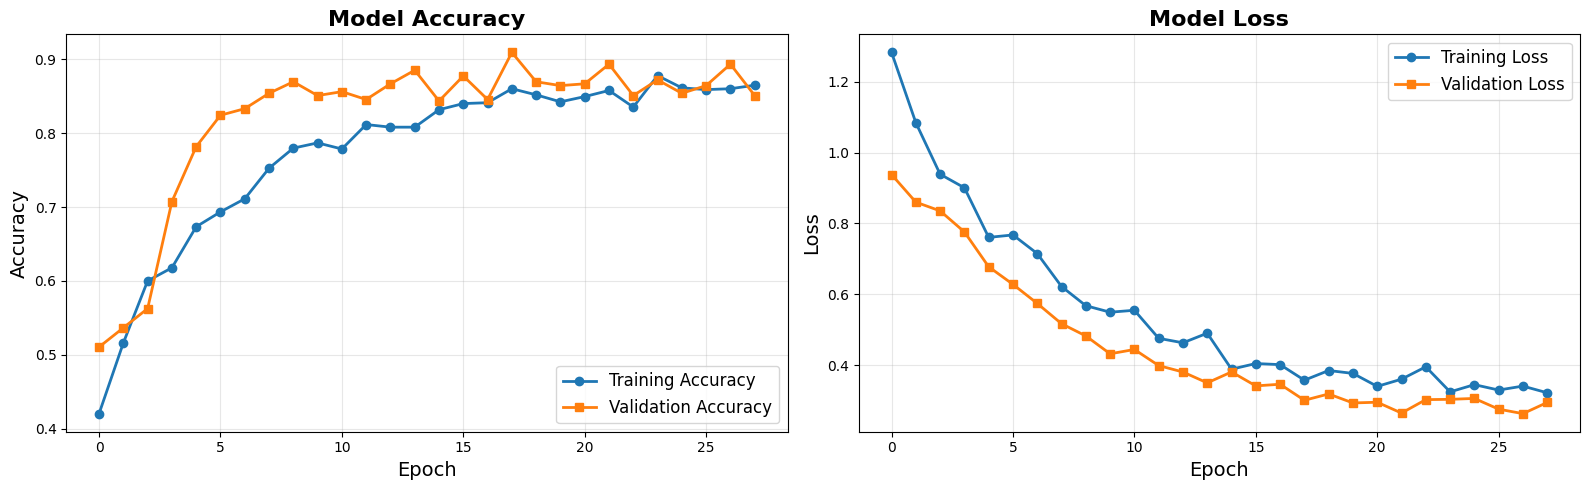


Best Performance:
  Epoch: 18
  Training Accuracy: 0.8604
  Validation Accuracy: 0.9096
  Training Loss: 0.3575
  Validation Loss: 0.3008


In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], 'o-', linewidth=2, label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], 's-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], 'o-', linewidth=2, label='Training Loss')
axes[1].plot(history.history['val_loss'], 's-', linewidth=2, label='Validation Loss')
axes[1].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Performance:")
print(f"  Epoch: {best_epoch + 1}")
print(f"  Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"  Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"  Training Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"  Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")

## 7. Model Evaluation

In [15]:
# Load best model
best_model = keras.models.load_model('/content/best_ensemble_model.h5')
print("✓ Best model loaded")

# Generate predictions on test set
print("\nGenerating predictions on test set...")
y_pred = []
y_true = []

steps = len(test_paths) // CONFIG['BATCH_SIZE']
for X_batch, y_batch in tqdm(datagen(test_paths, test_labels,
                                     batch_size=CONFIG['BATCH_SIZE'],
                                     epochs=1, augment=False),
                            total=steps):
    predictions = best_model.predict(X_batch, verbose=0)
    pred_classes = np.argmax(predictions, axis=-1)

    y_pred.extend(pred_classes)
    y_true.extend(y_batch)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print("✓ Predictions generated")

✓ Best model loaded

Generating predictions on test set...


7it [00:18,  2.70s/it]

✓ Predictions generated


In [16]:
# Print classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign     0.5556    0.2083    0.3030        24
   Malignant     0.9825    0.9912    0.9868       113
      Normal     0.8041    0.9398    0.8667        83

    accuracy                         0.8864       220
   macro avg     0.7807    0.7131    0.7188       220
weighted avg     0.8686    0.8864    0.8669       220



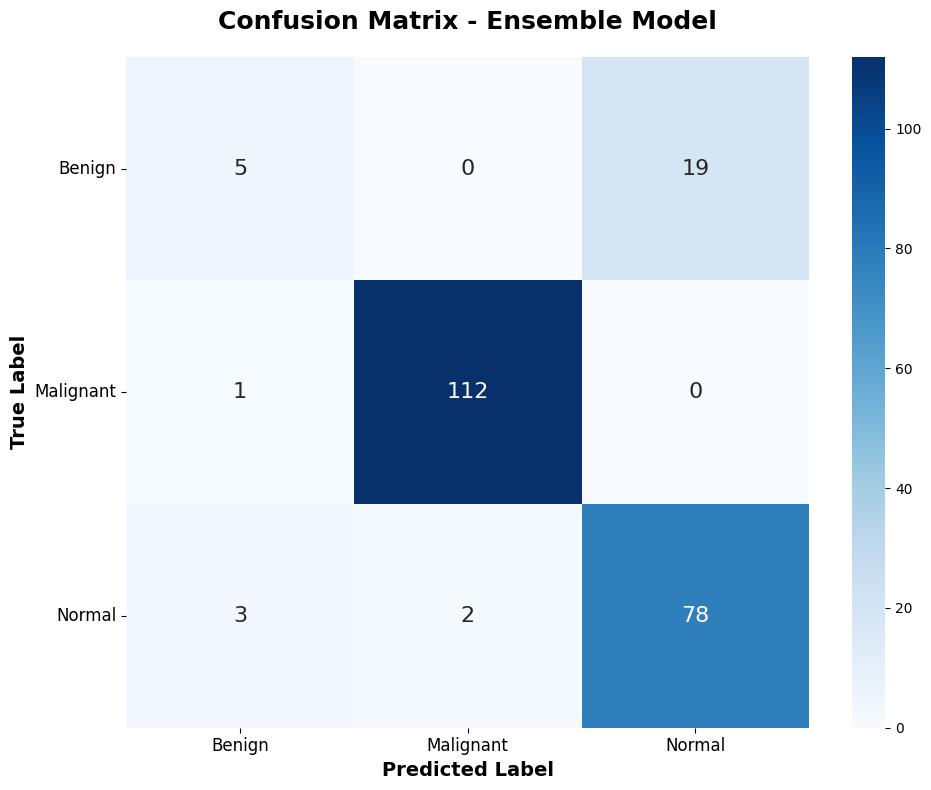

In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'fontsize': 16}, cbar=True)
plt.title('Confusion Matrix - Ensemble Model', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Calculate detailed metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(f"\nOverall Accuracy: {accuracy:.5f}")
print(f"\nMacro Metrics:")
print(f"  Precision: {precision_macro:.5f}")
print(f"  Recall: {recall_macro:.5f}")
print(f"  F1-Score: {f1_macro:.5f}")
print(f"\nWeighted Metrics:")
print(f"  Precision: {precision_weighted:.5f}")
print(f"  Recall: {recall_weighted:.5f}")
print(f"  F1-Score: {f1_weighted:.5f}")


DETAILED PERFORMANCE METRICS

Overall Accuracy: 0.88636

Macro Metrics:
  Precision: 0.78071
  Recall: 0.71308
  F1-Score: 0.71883

Weighted Metrics:
  Precision: 0.86861
  Recall: 0.88636
  F1-Score: 0.86688


In [19]:
# Per-class metrics for binary classification perspective
# (Useful for medical diagnosis where each class can be treated as positive)
print("\n" + "="*60)
print("PER-CLASS BINARY METRICS")
print("="*60)

for class_idx, class_name in enumerate(class_names):
    # Create binary labels (one-vs-rest)
    y_true_binary = (y_true == class_idx).astype(int)
    y_pred_binary = (y_pred == class_idx).astype(int)

    # Calculate confusion matrix for this class
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))

    # Calculate metrics
    accuracy_class = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity_class = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0

    print(f"\n{class_name.upper()} (as positive class):")
    print(f"  TP: {tp:4.0f}  |  TN: {tn:4.0f}")
    print(f"  FP: {fp:4.0f}  |  FN: {fn:4.0f}")
    print(f"  Accuracy:    {accuracy_class:.5f}")
    print(f"  Precision:   {precision_class:.5f}")
    print(f"  Recall:      {recall_class:.5f}")
    print(f"  Specificity: {specificity_class:.5f}")
    print(f"  F1-Score:    {f1_class:.5f}")


PER-CLASS BINARY METRICS

BENIGN (as positive class):
  TP:    5  |  TN:  192
  FP:    4  |  FN:   19
  Accuracy:    0.89545
  Precision:   0.55556
  Recall:      0.20833
  Specificity: 0.97959
  F1-Score:    0.30303

MALIGNANT (as positive class):
  TP:  112  |  TN:  105
  FP:    2  |  FN:    1
  Accuracy:    0.98636
  Precision:   0.98246
  Recall:      0.99115
  Specificity: 0.98131
  F1-Score:    0.98678

NORMAL (as positive class):
  TP:   78  |  TN:  118
  FP:   19  |  FN:    5
  Accuracy:    0.89091
  Precision:   0.80412
  Recall:      0.93976
  Specificity: 0.86131
  F1-Score:    0.86667


## 8. Save Final Model

In [20]:
# Save the final ensemble model
ensemble_model.save('/content/drive/MyDrive/ensemble_vgg19_mobilenet_resnet50.h5')
print("✓ Final ensemble model saved to Google Drive")

# Save model architecture as JSON
model_json = ensemble_model.to_json()
with open('/content/drive/MyDrive/ensemble_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✓ Model architecture saved as JSON")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)
print("✓ Training history saved as CSV")

print("\n" + "="*60)
print("ALL FILES SAVED SUCCESSFULLY!")
print("="*60)

✓ Final ensemble model saved to Google Drive
✓ Model architecture saved as JSON
✓ Training history saved as CSV

ALL FILES SAVED SUCCESSFULLY!
